<a href="https://colab.research.google.com/github/2kunal6/UniBonn/blob/master/cuda_lab/2/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
datasets loaded
Label: tensor(1)
epoch: 0, loss: -65.92375946044922
epoch: 1, loss: -131.7441864013672
epoch: 2, loss: -200.80767822265625
epoch: 3, loss: -266.4193420410156
epoch: 4, loss: -306.49090576171875
epoch: 5, loss: -374.3993835449219
epoch: 6, loss: -471.9295654296875
epoch: 7, loss: -574.9212646484375
epoch: 8, loss: -592.7531127929688
epoch: 9, loss: -633.2156372070312
Accuracy of the network on the 10000 test images: 11 %


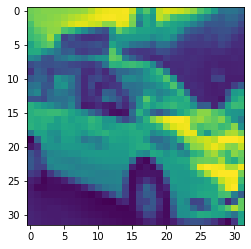

In [21]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import matplotlib.pyplot as plt

transform_list = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
            #transforms.Normalize([0.5,],[0.5,])
        ])
train = torch.utils.data.DataLoader(
    datasets.CIFAR10("./sample_data", train=True, transform=transform_list, download=True), batch_size = 32, shuffle = True
)

test = torch.utils.data.DataLoader(
    datasets.CIFAR10("./sample_data", train=False, transform=transform_list, download=True), batch_size = 32, shuffle = True
)

print("datasets loaded")

IMG_SIZE = 32*32

for data in train:
  X, y = data[0], data[1]
  plt.imshow(X[0].reshape(32, 32))
  print("Label: " + str(y[0]))
  break

class LogisticRegression(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(input_dim, output_dim)

  def forward(self, x):
    return self.linear(x)

model = LogisticRegression(IMG_SIZE, 10)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

for epoch in range(10):
  for data in train:
    X, y = data[0], data[1]
    optimizer.zero_grad()
    output = model(X.view(-1, IMG_SIZE))
    loss = F.nll_loss(output, y)
    loss.backward()
    optimizer.step()
  print(f'epoch: {epoch}, loss: {loss}')

total = 0
correct = 0

with torch.no_grad():
  for data in test:
    X, y = data[0], data[1]
    output = model(X.view(-1, IMG_SIZE))
    _, predicted = torch.max(output, 1)
    total += y.size(0)
    correct += (predicted == y).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))